In [ ]:
!pip install transformers
!pip install pytorch-crf
!mkdir models
!mkdir pretrained_model


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 31.3 MB/s 
     |████████████████████████████████| 6.6 MB 55.4 MB/s 
     |████████████████████████████████| 120 kB 65.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import AutoModel, AutoTokenizer

embedding_model_name="athiban2001/cord-scibert"

bert = AutoModel.from_pretrained(embedding_model_name)
tokenizer = AutoTokenizer.from_pretrained(embedding_model_name, use_fast=False)
bert.save_pretrained(f"./pretrained_model/cord-scibert")
tokenizer.save_pretrained("./pretrained_model/cord-scibert")


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Downloading:   0%|          | 0.00/644 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of the model checkpoint at athiban2001/cord-scibert were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at athiban2001/cord-scibert and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.

Downloading:   0%|          | 0.00/359 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/264k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/19.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

('./pretrained_model/cord-scibert/tokenizer_config.json',
 './pretrained_model/cord-scibert/special_tokens_map.json',
 './pretrained_model/cord-scibert/vocab.txt',
 './pretrained_model/cord-scibert/added_tokens.json')

In [ ]:
import transformers

DEVICE = 'cuda'
MAX_LEN = 256
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS =5
NUM_WORKER =4
BASE_MODEL_PATH = "./pretrained_model/cord-scibert"
MODEL_PATH = "models/JNLPBA_covbert"
TRAINING_FILE = "../input/jnlpba"
TOKENIZER = transformers.BertTokenizer.from_pretrained(
    BASE_MODEL_PATH,
    do_lower_case=True
)


In [ ]:
import torch

class EntityDataset:
    def __init__(self, texts, tags,enc_tag):
        # texts: [["hi", ",", "my", "name", "is", "abhishek"], ["hello".....]]
        # pos/tags: [[1 2 3 4 1 5], [....].....]]
        self.texts = texts
        # self.pos = pos
        self.tags = tags
        self.enc_tag=enc_tag
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, item):
        text = self.texts[item]
        # pos = self.pos[item]
        tags = self.tags[item]

        ids = []
        # target_pos = []
        target_tag =[]

        for i, s in enumerate(text):
            inputs = TOKENIZER.encode(
                str(s),
                add_special_tokens=False
            )
            # abhishek: ab ##hi ##sh ##ek
            input_len = len(inputs)
            ids.extend(inputs)
            # target_pos.extend([pos[i]] * input_len)
            target_tag.extend([tags[i]] * input_len)
        '''print("input:  ",inputs)
        print("ids  ",ids)'''
        ids = ids[:MAX_LEN - 2]
        # target_pos = target_pos[:MAX_LEN - 2]
        #print("ids  ",ids)
        target_tag = target_tag[:MAX_LEN - 2]
        #print("tag ",target_tag)

        ids = [102] + ids + [103]
        #print("ids  ",ids)
        # target_pos = [0] + target_pos + [0]
        o_tag=self.enc_tag.transform(["O"])[0]
        #print("o_tag ",o_tag)
        target_tag = [o_tag] + target_tag + [o_tag]
        #print("tag ",target_tag)

        mask = [1] * len(ids)
        #print(mask)
        token_type_ids = [0] * len(ids)
        #print(token_type_ids)
        padding_len = MAX_LEN - len(ids)
        #print(padding_len)
        ids = ids + ([0] * padding_len)
        #print(ids)
        mask = mask + ([0] * padding_len)
        #print(mask)
        token_type_ids = token_type_ids + ([0] * padding_len)
        # target_pos = target_pos + ([0] * padding_len)
        #print(token_type_ids)
        target_tag = target_tag + ([0] * padding_len)
        #print(target_tag)

        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            # "target_pos": torch.tensor(target_pos, dtype=torch.long),
            "target_tag": torch.tensor(target_tag, dtype=torch.long),
            # "words":torch.tensor(words,dtype=torch.int)
        }


In [ ]:
import torch
import transformers
import torch.nn as nn
from torchcrf import CRF

In [ ]:

class EntityModel(nn.Module):
    def __init__(self, num_tag):
        super(EntityModel, self).__init__()
        self.num_tag = num_tag
        self.bert = transformers.BertModel.from_pretrained(BASE_MODEL_PATH,return_dict=False)
        self.bilstm= nn.LSTM(768, 1024 // 2, num_layers=1, bidirectional=True, batch_first=True)

        self.dropout_tag = nn.Dropout(0.3)
        
        self.hidden2tag_tag = nn.Linear(1024, self.num_tag)

        self.crf_tag = CRF(self.num_tag, batch_first=True)
    
    
    # return the loss only, not encode the tag
    def forward(self, ids, mask, token_type_ids, target_tag):
        x, _ = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
        #print(x.size())
        h, _ = self.bilstm(x)
        #print(h.size())
        o_tag = self.dropout_tag(h)
        #print(o_tag.size())
        tag = self.hidden2tag_tag(o_tag)
        
        #print(tag.size())
        mask = torch.where(mask==1, True, False)
        loss_tag = -self.crf_tag(tag, target_tag, mask=mask, reduction='token_mean')
        loss=loss_tag
        
        return loss


    # encode the tag, dont return loss
    def encode(self, ids, mask, token_type_ids, target_tag):
        # Bert - BiLSTM
        x, _ = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
        h, _ = self.bilstm(x)

        # drop out
        o_tag = self.dropout_tag(h)
        # o_pos = self.dropout_pos(h)

        # Hidden2Tag (Linear)
        tag = self.hidden2tag_tag(o_tag)
        mask = torch.where(mask==1, True, False)
        tag = self.crf_tag.decode(tag, mask=mask)

        return tag


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

import joblib
import torch
import torch.utils.data

from sklearn import preprocessing
from sklearn import model_selection

total_tags=[]
with open("../content/drive/MyDrive/thesis/classes.txt") as f:
  for line in f.readlines():
    total_tags.append(line.strip())

enc_tag = preprocessing.LabelEncoder()
enc_tag.fit(list(total_tags))

def process_data(data_path):
    sentences,tags=[],[]
    sentence,tag=[],[]
    
    total_tags=set()
    i=0
    
    for path in data_path:
        with open(path,"r") as f:
            for line in f:
                if i%10000==0:
                  print(len(sentences))
                i+=1
                line=line.strip()
                if line.startswith("-DOCSTART-"):
                    continue
                elif len(line)==0:
                    if sentence==[] and tag==[]:
                        continue
                    sentences.append(sentence)
                    tags.append(tag)
                    sentence,tag=[],[]
                else:
                    s,t=line.split("\t")
                    sentence.append(s)
                    tag.append(t)

    for i in range(len(tags)):
        tags[i]=enc_tag.transform(tags[i])
                
    return sentences, tags, enc_tag


In [ ]:
from __future__ import division, print_function, unicode_literals

import sys
from collections import defaultdict

def split_tag(chunk_tag):
    """
    split chunk tag into IOBES prefix and chunk_type
    e.g. 
    B-PER -> (B, PER)
    O -> (O, None)
    """
    if chunk_tag == 'O':
        return ('O', None)
    return chunk_tag.split("-",maxsplit=1)

def is_chunk_end(prev_tag, tag):
    """
    check if the previous chunk ended between the previous and current word
    e.g. 
    (B-PER, I-PER) -> False
    (B-LOC, O)  -> True
    Note: in case of contradicting tags, e.g. (B-PER, I-LOC)
    this is considered as (B-PER, B-LOC)
    """
    prefix1, chunk_type1 = split_tag(prev_tag)
    prefix2, chunk_type2 = split_tag(tag)

    if prefix1 == 'O':
        return False
    if prefix2 == 'O':
        return prefix1 != 'O'

    if chunk_type1 != chunk_type2:
        return True

    return prefix2 in ['B', 'S'] or prefix1 in ['E', 'S']

def is_chunk_start(prev_tag, tag):
    """
    check if a new chunk started between the previous and current word
    """
    prefix1, chunk_type1 = split_tag(prev_tag)
    prefix2, chunk_type2 = split_tag(tag)

    if prefix2 == 'O':
        return False
    if prefix1 == 'O':
        return prefix2 != 'O'

    if chunk_type1 != chunk_type2:
        return True

    return prefix2 in ['B', 'S'] or prefix1 in ['E', 'S']


def calc_metrics(tp, p, t, percent=True):
    """
    compute overall precision, recall and FB1 (default values are 0.0)
    if percent is True, return 100 * original decimal value
    """
    precision = tp / p if p else 0
    recall = tp / t if t else 0
    fb1 = 2 * precision * recall / (precision + recall) if precision + recall else 0
    if percent:
        return 100 * precision, 100 * recall, 100 * fb1
    else:
        return precision, recall, fb1


def count_chunks(true_seqs, pred_seqs):
    """
    true_seqs: a list of true tags
    pred_seqs: a list of predicted tags
    return: 
    correct_chunks: a dict (counter), 
                    key = chunk types, 
                    value = number of correctly identified chunks per type
    true_chunks:    a dict, number of true chunks per type
    pred_chunks:    a dict, number of identified chunks per type
    correct_counts, true_counts, pred_counts: similar to above, but for tags
    """
    correct_chunks = defaultdict(int)
    true_chunks = defaultdict(int)
    pred_chunks = defaultdict(int)

    correct_counts = defaultdict(int)
    true_counts = defaultdict(int)
    pred_counts = defaultdict(int)

    prev_true_tag, prev_pred_tag = 'O', 'O'
    correct_chunk = None

    for true_tag, pred_tag in zip(true_seqs, pred_seqs):
        if true_tag == pred_tag:
            correct_counts[true_tag] += 1
        true_counts[true_tag] += 1
        pred_counts[pred_tag] += 1

        _, true_type = split_tag(true_tag)
        _, pred_type = split_tag(pred_tag)

        if correct_chunk is not None:
            true_end = is_chunk_end(prev_true_tag, true_tag)
            pred_end = is_chunk_end(prev_pred_tag, pred_tag)

            if pred_end and true_end:
                correct_chunks[correct_chunk] += 1
                correct_chunk = None
            elif pred_end != true_end or true_type != pred_type:
                correct_chunk = None

        true_start = is_chunk_start(prev_true_tag, true_tag)
        pred_start = is_chunk_start(prev_pred_tag, pred_tag)

        if true_start and pred_start and true_type == pred_type:
            correct_chunk = true_type
        if true_start:
            true_chunks[true_type] += 1
        if pred_start:
            pred_chunks[pred_type] += 1

        prev_true_tag, prev_pred_tag = true_tag, pred_tag
    if correct_chunk is not None:
        correct_chunks[correct_chunk] += 1

    return (correct_chunks, true_chunks, pred_chunks, 
        correct_counts, true_counts, pred_counts)

def get_result(correct_chunks, true_chunks, pred_chunks,
    correct_counts, true_counts, pred_counts, verbose=True):
    
    # sum counts
    sum_correct_chunks = sum(correct_chunks.values())
    sum_true_chunks = sum(true_chunks.values())
    sum_pred_chunks = sum(pred_chunks.values())

    sum_correct_counts = sum(correct_counts.values())
    sum_true_counts = sum(true_counts.values())

    nonO_correct_counts = sum(v for k, v in correct_counts.items() if k != 'O')
    nonO_true_counts = sum(v for k, v in true_counts.items() if k != 'O')

    chunk_types = sorted(list(set(list(true_chunks) + list(pred_chunks))))

    # compute overall precision, recall and FB1 (default values are 0.0)
    '''prec, rec, f1 = calc_metrics(sum_correct_chunks, sum_pred_chunks, sum_true_chunks)
    res = (prec, rec, f1)
    if not verbose:
        return res

    # print overall performance, and performance per chunk type
    
    print("processed %i tokens with %i phrases; " % (sum_true_counts, sum_true_chunks), end='')
    print("found: %i phrases; correct: %i.\n" % (sum_pred_chunks, sum_correct_chunks), end='')
        
    print("accuracy: %6.2f%%; (non-O)" % (100*nonO_correct_counts/nonO_true_counts))
    print("accuracy: %6.2f%%; " % (100*sum_correct_counts/sum_true_counts), end='')
    print("precision: %6.2f%%; recall: %6.2f%%; FB1: %6.2f" % (prec, rec, f1))'''

    # for each chunk type, compute precision, recall and FB1 (default values are 0.0)
    for t in chunk_types:
        prec, rec, f1 = calc_metrics(correct_chunks[t], pred_chunks[t], true_chunks[t])
        print("%17s: " %t , end='')
        print("precision: %6.2f%%; recall: %6.2f%%; FB1: %6.2f" %
                    (prec, rec, f1), end='')
        print("  %d" % pred_chunks[t])
        res = (prec, rec, f1)

    return res
    # you can generate LaTeX output for tables like in
    # http://cnts.uia.ac.be/conll2003/ner/example.tex
    # but I'm not implementing this
def evaluate(true_seqs, pred_seqs, verbose=True):
    (correct_chunks, true_chunks, pred_chunks,
        correct_counts, true_counts, pred_counts) = count_chunks(true_seqs, pred_seqs)
    result = get_result(correct_chunks, true_chunks, pred_chunks,
        correct_counts, true_counts, pred_counts, verbose=verbose)
    return result


In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report
import sklearn.metrics as metrics
import scikitplot as skplt
import matplotlib.pyplot as plt
def train_fn(data_loader, model, optimizer, device):
    model.train()
    final_loss = 0
    for data in tqdm(data_loader, total=len(data_loader)):
        for k, v in data.items():
            data[k] = v.to(device)
        optimizer.zero_grad()
        loss = model(**data)
        loss.backward()
        optimizer.step()
        final_loss += loss.item()
    return final_loss / len(data_loader)

def eval_fn(data_loader, model, device):
    model.eval()
    final_loss = 0

    for data in tqdm(data_loader, total=len(data_loader)):
        for k, v in data.items():
            data[k] = v.to(device)
        loss = model(**data)
        final_loss += loss.item()
    return final_loss / len(data_loader)

def load_model(epochs):
  path=MODEL_PATH+f"_{epochs}.bin"
  device = torch.device(DEVICE)
  model = EntityModel(num_tag=num_tag)
  model.load_state_dict(torch.load(path))
  model.to(device)
  return model

In [ ]:
if __name__ == "__main__":
    sentences, tag, enc_tag = process_data(["../content/drive/MyDrive/thesis/train.tsv","../content/drive/MyDrive/thesis/devel.tsv"])
    test_sentences, test_tag, _ = process_data(["../content/drive/MyDrive/thesis/test.tsv"])

    meta_data = {
        "enc_tag": enc_tag
    }

    joblib.dump(meta_data, "meta.bin")

    num_tag = len(list(enc_tag.classes_))

    (
        train_sentences,
        valid_sentences,
        train_tag,
        valid_tag
    ) = model_selection.train_test_split(sentences, tag, random_state=42, test_size=0.1)

    train_dataset = EntityDataset(texts=train_sentences, tags=train_tag,enc_tag=enc_tag)

    train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKER)

    valid_dataset = EntityDataset(texts=valid_sentences, tags=valid_tag,enc_tag=enc_tag)

    valid_data_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=VALID_BATCH_SIZE, num_workers=NUM_WORKER)

    test_dataset=EntityDataset(texts=test_sentences,tags=test_tag,enc_tag=enc_tag)
    test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=VALID_BATCH_SIZE, num_workers=NUM_WORKER)


    device = torch.device(DEVICE)
    model = EntityModel(num_tag=num_tag)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # optimizer = torch.optim.Adam(model.parameters(), lr=3e-5, weight_decay=0.001)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


0
385
766
1146
1532
1907
2300
2690
3083
3459
3839
4249
4631
5007
5383
5765
6125
0
370
734


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
sum(p.numel() for p in model.parameters())

115916584

In [ ]:
from prettytable import PrettyTable
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+---------------------------------------------------------+------------+
|                         Modules                         | Parameters |
+---------------------------------------------------------+------------+
|          bert.embeddings.word_embeddings.weight         |  24619008  |
|        bert.embeddings.position_embeddings.weight       |   393216   |
|       bert.embeddings.token_type_embeddings.weight      |    1536    |
|             bert.embeddings.LayerNorm.weight            |    768     |
|              bert.embeddings.LayerNorm.bias             |    768     |
|     bert.encoder.layer.0.attention.self.query.weight    |   589824   |
|      bert.encoder.layer.0.attention.self.query.bias     |    768     |
|      bert.encoder.layer.0.attention.self.key.weight     |   589824   |
|       bert.encoder.layer.0.attention.self.key.bias      |    768     |
|     bert.encoder.layer.0.attention.self.value.weight    |   589824   |
|      bert.encoder.layer.0.attention.self.value.bi

115916584

In [ ]:
tr_loss=[]
val_loss=[]


In [ ]:
from prettytable import PrettyTable

#data={}
#df_list=[]
epochlist=[]
table = PrettyTable(["EPOCH", "Train_loss","Validation_Loss"])
for epoch in range(EPOCHS):
    epochlist.append(epoch)
    train_loss = train_fn(train_data_loader, model, optimizer, device)
    tr_loss.append(train_loss)
    torch.cuda.empty_cache()
    valid_loss = eval_fn(valid_data_loader, model, device)
    val_loss.append(valid_loss)
    table.add_row([epoch,train_loss,valid_loss])
    #data[epoch] = [(epoch,train_loss,valid_loss)]
    #df = pd.DataFrame(data, columns =['Name', 'Age', 'Score'])
    torch.cuda.empty_cache()
    print(f"Train Loss = {train_loss}")
    print(f"Validation Loss = {valid_loss}")
    #test_fn(test_dataset, model, device,enc_tag)
    torch.save(model.state_dict(), MODEL_PATH+f"_{epoch}.bin")
dict={"Epoch":epochlist,"train_loss":tr_loss,"valid_loss":val_loss}
df=pd.DataFrame(dict)

100%|██████████| 40/40 [00:22<00:00,  1.81it/s]


Train Loss = 0.17877372000522973
Validation Loss = 0.0842275193426758


100%|██████████| 40/40 [00:21<00:00,  1.85it/s]


Train Loss = 0.05831308062488333
Validation Loss = 0.05748721375130117


100%|██████████| 40/40 [00:21<00:00,  1.88it/s]


Train Loss = 0.033091251390753966
Validation Loss = 0.056546469929162416


100%|██████████| 40/40 [00:21<00:00,  1.86it/s]


Train Loss = 0.025238549324399492
Validation Loss = 0.053190608904697


100%|██████████| 40/40 [00:21<00:00,  1.86it/s]


Train Loss = 0.016889350633241276
Validation Loss = 0.05553554606158286


In [ ]:
from google.colab import files
df.to_csv("abc.csv",header=False,index=False)
files.download('abc.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(table)

+-------+----------------------+----------------------+
| EPOCH |      Train_loss      |   Validation_Loss    |
+-------+----------------------+----------------------+
|   0   | 0.17877372000522973  |  0.0842275193426758  |
|   1   | 0.05831308062488333  | 0.05748721375130117  |
|   2   | 0.033091251390753966 | 0.056546469929162416 |
|   3   | 0.025238549324399492 |  0.053190608904697   |
|   4   | 0.016889350633241276 | 0.05553554606158286  |
+-------+----------------------+----------------------+


In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt

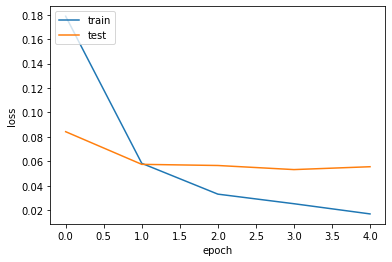

In [ ]:
g=plt.figure(3)
plt.plot(tr_loss)
plt.plot(val_loss)
#plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
g.savefig("lossvsepoch.pdf")
files.download("lossvsepoch.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import precision_recall_curve,roc_curve, auc
import torch.nn.functional as F


In [ ]:
def test_fn(dataset,model,device,enc_tag):
  final_test = []
  final_pred = []
  O=enc_tag.transform(["O"])[0]
  #y_prob=[]
  with torch.no_grad():
    for data in tqdm(dataset):
      for k, v in data.items():
          data[k] = v.to(device).unsqueeze(0)
      #label_id=label_id.to(device)
      '''logits,_= model(**data)
      logits = F.softmax(logits,dim=1)
      a=logits.cpu().numpy()
      y_prob.append(a)
      y_prob = np.concatenate(y_prob)
      labels=data["target_tag"].cpu()
      #probs =torch.softmax(logits, dim=1) # assuming logits has the shape [batch_size, nb_classes]
      #preds =torch.argmax(logits, dim=1)'''
      tag = model.encode(**data)
      #yhat = model.predict_proba(**data)
      padded_pred=tag[0]
      test=data["target_tag"].cpu()[0][:len(padded_pred)]
      test=enc_tag.inverse_transform(test)
      padded_pred=enc_tag.inverse_transform(padded_pred)
      final_pred.extend(padded_pred[1:-1])
      final_test.extend(test[1:-1])
        
    return final_pred,final_test
  #print(multilabel_confusion_matrix(final_test, final_pred))
  #print(classification_report(final_test, final_pred))
  #Roc_curve(final_test, final_pred)
  

In [ ]:
torch.cuda.empty_cache()
#test_fn(test_dataset, model, device,enc_tag)

In [ ]:
pred,y_test=test_fn(test_dataset, model, device,enc_tag)

100%|██████████| 939/939 [01:05<00:00, 14.41it/s]


In [ ]:
y_true=[]
y_pred=[]
tag2idx={
    "B-Disease":0,
    "E-Disease":1,
    "I-Disease":2,
    "S-Disease":3,
    "O":4
}
for i in range(0,len(y_test)):
  y_true.append(tag2idx[y_test[i]])
  y_pred.append(tag2idx[pred[i]])


In [ ]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       759
           1       0.86      0.93      0.90       729
           2       0.77      0.91      0.84       718
           3       0.91      0.91      0.91       745
           4       0.99      0.99      0.99     24955

    accuracy                           0.98     27906
   macro avg       0.88      0.92      0.90     27906
weighted avg       0.98      0.98      0.98     27906



In [ ]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
# 5 classes to classify
n_classes = 5

#X, y = make_classification(n_samples=80000, n_features=20, n_informative=3, n_redundant=0, n_classes=n_classes,n_clusters_per_class=2)
# Binarize the output
y_true= label_binarize(y_true, classes=[0,1,2,3,4])
y_pred= label_binarize(y_pred, classes= [0,1,2,3,4])
n_classes = y_true.shape[1]
print(y_true)
print(n_classes)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

[[0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]
 ...
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 0 0 0 1]]
5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


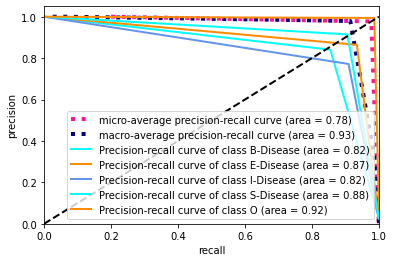

In [ ]:
import numpy as np
from scipy import interp
from itertools import cycle
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
precision = defaultdict()
recall = defaultdict()
pre_auc = defaultdict()
for i in range(n_classes):
    precision[i],recall[i], _ = precision_recall_curve(y_true[:, i],y_pred[:,i])
    pre_auc[i] = auc(precision[i],recall[i])
precision[4][0]= 0.0697845
'''precision[4][1]= 0.95792325
precision[4][2]= 1.
recall[4][0]= 1.
recall[4][1]= 0.70244841
recall[4][2]= 0.'''
pre_auc[i] = auc(precision[i],recall[i])
# Compute micro-average ROC curve and ROC area
precision["micro"], recall["micro"], _ = precision_recall_curve(y_true.ravel(), y_pred.ravel())
pre_auc["micro"] = auc(precision["micro"], recall["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_precision = np.unique(np.concatenate([precision[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_recall= np.zeros_like(all_precision)
for i in range(n_classes):
    mean_recall += interp(all_precision, precision["micro"], recall["micro"])

# Finally average it and compute AUC
mean_recall/= n_classes

precision["macro"] = all_precision
recall["macro"] = mean_recall
pre_auc["macro"] = auc(precision["macro"], recall["macro"])
l=["B-Disease","E-Disease","I-Disease","S-Disease","O"]

# Plot all ROC curves
h=plt.figure(1)
plt.plot(precision["micro"], recall["micro"],
         label='micro-average precision-recall curve (area = {0:0.2f})'
               ''.format(pre_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(precision["macro"], recall["macro"],
         label='macro-average precision-recall curve (area = {0:0.2f})'
               ''.format(pre_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i],precision[i], color=color, lw=lw,
             label='Precision-recall curve of class {0} (area = {1:0.2f})'
             ''.format(l[i], pre_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('precision')
plt.xlabel('recall')
#plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


In [ ]:
for i in range(n_classes):
  print(precision[i])
  print(recall[i])

[0.02719845 0.84067358 1.        ]
[1.         0.85507246 0.        ]
[0.02612341 0.8642132  1.        ]
[1.         0.93415638 0.        ]
[0.02572923 0.77186761 1.        ]
[1.         0.90947075 0.        ]
[0.02669677 0.91463415 1.        ]
[1.         0.90604027 0.        ]
[0.0697845  0.99406348 1.        ]
[1.         0.98637548 0.        ]


In [ ]:
h.savefig("precrecall.pdf", bbox_inches='tight')
files.download("precrecall.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


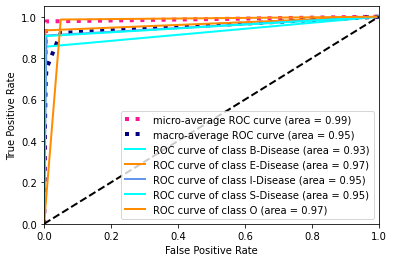

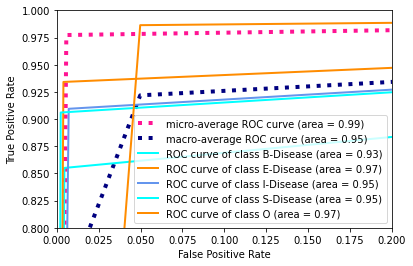

In [ ]:
import numpy as np
from scipy import interp
from itertools import cycle
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = defaultdict()
tpr = defaultdict()
roc_auc = defaultdict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
l=["B-Disease","E-Disease","I-Disease","S-Disease","O"]

# Plot all ROC curves
f=plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(l[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(l[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
f.savefig("ROC.pdf", bbox_inches='tight')
files.download("ROC.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
for i in range(n_classes):
  print(fpr[i])
  print(tpr[i])

[0.         0.00453089 1.        ]
[0.         0.85507246 1.        ]
[0.         0.00393715 1.        ]
[0.         0.93415638 1.        ]
[0.         0.00709872 1.        ]
[0.         0.90947075 1.        ]
[0.        0.0023195 1.       ]
[0.         0.90604027 1.        ]
[0.         0.04981362 1.        ]
[0.         0.98637548 1.        ]
